# GPT-2 model architecture



In [56]:
GPT_CONFIG = {
    "vocab_size": 50257,
    "context_size": 1024,
    "embed_dim": 768,
    "num_heads": 12,
    "num_layers": 12,
    "dropout": 0.1,
    "qkv_bias": False,
}

In [57]:
import torch
import torch.nn as nn

In [58]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")
batch = []
text1 = "Every effort move you"
text2 = "Every dat holds a"

batch.append(torch.tensor(tokenizer.encode(text1), dtype=torch.long))
batch.append(torch.tensor(tokenizer.encode(text2), dtype=torch.long))

batch = torch.stack(batch)
print(batch)

tensor([[6109, 3626, 1445,  345],
        [6109, 4818, 6622,  257]])


In [59]:
class LayerNorm(nn.Module):
    """Implements Layer Normalization"""

    def __init__(self, dim, eps=1e-5):
        super().__init__()
        self.eps = eps
        self.gamma = nn.Parameter(torch.ones(dim))
        self.beta = nn.Parameter(torch.zeros(dim))

    def forward(self, x):
        """
        Forward pass of layer normalization
        Args:
            x: Input tensor of shape (batch_size, seq_length, dim)
        Returns:
            out: Layer-normalized tensor of the same shape as input
        """

        mean = x.mean(-1, keepdim=True)
        var = x.var(-1, keepdim=True, unbiased=False)
        x_hat = (x - mean) / torch.sqrt(var + self.eps)
        out = self.gamma * x_hat + self.beta
        return out

In [60]:
class GELU(nn.Module):
    """Implements the GELU activation function"""

    def __init__(self):
        super().__init__()

    def forward(self, x):
        """
        Forward pass of GELU activation
        Args:
            x: Input tensor
        Returns:
            out: Tensor after applying GELU activation
        """
        return (
            0.5
            * x
            * (
                1
                + torch.tanh(
                    torch.sqrt(torch.tensor(2.0 / torch.pi))
                    * (x + 0.044715 * torch.pow(x, 3))
                )
            )
        )

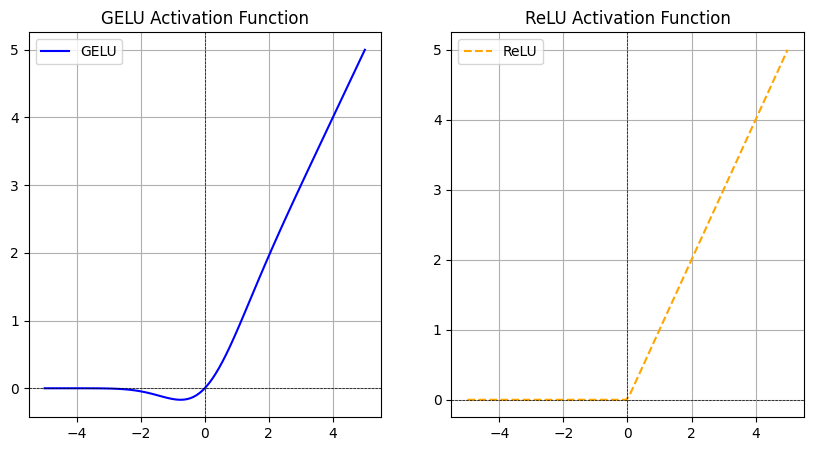

In [61]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

x = np.linspace(-5, 5, 100)
y = 0.5 * x * (1 + np.tanh(np.sqrt(2 / np.pi) * (x + 0.044715 * x**3)))
ax[0].plot(x, y, label="GELU", color="blue")
ax[1].plot(x, np.maximum(0, x), label="ReLU", color="orange", linestyle="--")
ax[0].set_title("GELU Activation Function")
ax[1].set_title("ReLU Activation Function")
ax[0].axhline(0, color="black", linewidth=0.5, ls="--")
ax[0].axvline(0, color="black", linewidth=0.5, ls="--")
ax[1].axhline(0, color="black", linewidth=0.5, ls="--")
ax[1].axvline(0, color="black", linewidth=0.5, ls="--")
ax[0].grid()
ax[1].grid()
ax[0].legend()
ax[1].legend()
plt.show()

In [62]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["embed_dim"], 4 * cfg["embed_dim"]),
            GELU(),
            nn.Linear(4 * cfg["embed_dim"], cfg["embed_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

In [63]:
from llm_from_papers.models.attention import MultiHeadAttention


class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["embed_dim"],
            d_out=cfg["embed_dim"],
            num_heads=cfg["num_heads"],
            context_length=cfg["context_size"],
            dropout=cfg["dropout"],
            qkv_bias=cfg["qkv_bias"],
        )
        self.feed_forward = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["embed_dim"])
        self.norm2 = LayerNorm(cfg["embed_dim"])
        self.dropout_shortcut = nn.Dropout(cfg["dropout"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut

        shortcut = x
        x = self.norm2(x)
        x = self.feed_forward(x)
        x = self.dropout_shortcut(x)
        x = x + shortcut

        return x

In [64]:
torch.manual_seed(42)

x = torch.randn(2, 10, GPT_CONFIG["embed_dim"])
block = TransformerBlock(GPT_CONFIG)
output = block(x)
output.shape

torch.Size([2, 10, 768])

In [65]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.token_embedding = nn.Embedding(cfg["vocab_size"], cfg["embed_dim"])
        self.position_embedding = nn.Embedding(cfg["context_size"], cfg["embed_dim"])
        self.dropout_embed = nn.Dropout(cfg["dropout"])
        self.transfomer_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["num_layers"])]
        )
        self.final_norm = LayerNorm(cfg["embed_dim"])
        self.lm_head = nn.Linear(cfg["embed_dim"], cfg["vocab_size"], bias=False)

    def forward(self, x):
        bz, sq_len = x.size()

        token_emb = self.token_embedding(x)  # (bz, sq_len, embed_dim)

        positions = torch.arange(sq_len, device=x.device)
        pos_emb = self.position_embedding(positions)  # (sq_len, embed_dim)

        x = token_emb + pos_emb  # (bz, sq_len, embed_dim)
        x = self.dropout_embed(x)

        x = self.transfomer_blocks(x)
        x = self.final_norm(x)

        logits = self.lm_head(x)  # (bz, sq_len, vocab_size)
        return logits

In [66]:
torch.manual_seed(42)

model = GPTModel(GPT_CONFIG)
logits = model(batch)
print(f"input : {batch}")
print(f"logits: {logits}")
logits.shape

input : tensor([[6109, 3626, 1445,  345],
        [6109, 4818, 6622,  257]])
logits: tensor([[[-0.9407,  0.0299,  0.3015,  ..., -0.8873, -0.3914,  0.3496],
         [ 0.0791, -0.2978,  0.5970,  ...,  0.1537, -0.3366, -0.5947],
         [-0.6475,  0.7965,  0.1390,  ...,  1.5598,  0.1051,  0.4081],
         [ 0.1372,  0.7794,  0.2523,  ...,  0.2250, -0.8584, -0.0786]],

        [[-0.8006,  0.1830, -0.4456,  ..., -1.3904, -0.0753,  0.3379],
         [ 0.5357,  0.5725,  0.0822,  ...,  0.6960, -0.5497,  0.1221],
         [-0.1746,  1.0972,  0.4571,  ...,  1.2321,  0.0834,  1.2664],
         [-0.2265, -0.3836,  1.4785,  ...,  0.5491, -0.2281, -0.8618]]],
       grad_fn=<UnsafeViewBackward0>)


torch.Size([2, 4, 50257])

In [67]:
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters in GPT-2 model: {total_params:,}")

Total parameters in GPT-2 model: 163,009,536


In [68]:
def genrate_simple_text(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]  # (bz, vocab_size)
        probas = torch.softmax(logits, dim=-1)  # (bz, vocab_size)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (bz, 1)
        idx = torch.cat((idx, idx_next), dim=1)  # (bz
    return idx



In [69]:
start_context = "Every effort"
encoded_context = tokenizer.encode(start_context)
encoded_tensor = torch.tensor(encoded_context, dtype=torch.long).unsqueeze(0)
print(f"Context: {start_context}")
print(f"Encoded context: {encoded_context}")
print(f"Encoded tensor: {encoded_tensor}")

Context: Every effort
Encoded context: [6109, 3626]
Encoded tensor: tensor([[6109, 3626]])


In [70]:
model.eval()
out = genrate_simple_text(model, encoded_tensor, max_new_tokens=6, context_size=GPT_CONFIG["context_size"])
print(f"Output tensor: {out}")


Output tensor: tensor([[ 6109,  3626, 30236, 43625,  1106, 32062, 34412, 46366]])


In [71]:
decoded = tokenizer.decode(out[0].tolist())
print(f"Decoded output: {decoded}")

Decoded output: Every effort MollyNormally.... 1915 trustworthy STOR
